In [1]:
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import os
import glob
from tqdm import tqdm

from util import load_positive_samples, load_negative_samples

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

In [2]:
positive_samples = load_positive_samples()
negative_samples = load_negative_samples()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.86it/s]


In [3]:
def plot_img(samples, select_num=12):   
    num_samples = len(samples)
    selected_index = np.random.choice(num_samples, select_num, replace=True)
    
    count = 0
    for index in selected_index:
        count += 1     
        plt_idx = count
        plt.subplot(1, select_num, plt_idx)
        plt.imshow(samples[index])
        plt.axis('off')
        
    plt.show()

6126


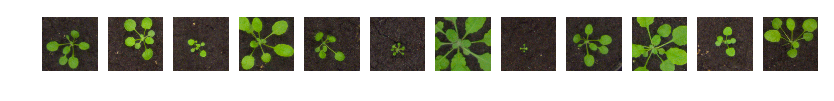

In [4]:
print(len(positive_samples))
plot_img(positive_samples)

11916


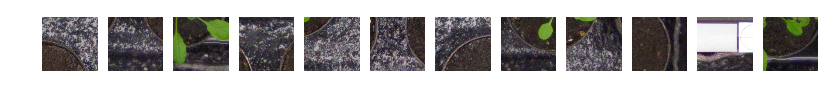

In [5]:
print(len(negative_samples))
plot_img(negative_samples)

In [6]:
def Hog_feature(img):
    orientations = 9
    pixels_per_cell = [8, 8]
    cells_per_block = [3, 3]
    visualize = False
    normalize = True
    
    im=Image.fromarray(img)
    im=im.convert('L')
    
    fd = hog(im, orientations, 
         pixels_per_cell, cells_per_block, 
         visualize, normalize)
    
    return fd

In [7]:
positive_fds= []
for img in tqdm(positive_samples):
    positive_fds.append(Hog_feature(img))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6126/6126 [01:36<00:00, 63.44it/s]


In [8]:
negative_fds= []
# sample_indexes = np.random.choice(len(negative_samples), 3000, replace=False)
# for idx in tqdm(sample_indexes):
for img in tqdm(negative_samples):
    negative_fds.append(Hog_feature(img))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11916/11916 [03:09<00:00, 62.77it/s]


In [9]:
from sklearn.model_selection import train_test_split

labels = []
fds = []
for sample in positive_fds:
    fds.append(sample)
    labels.append([1, 0])
    
for sample in negative_fds:
    fds.append(sample)
    labels.append([0, 1])

del positive_fds
del negative_fds
del positive_samples
del negative_samples

X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.3, random_state=0)

In [16]:
from svm_model import svm

model, callback_list = svm(input_size=54756)
hist = model.fit(np.array(X_train), np.array(y_train), batch_size=32, epochs=10, verbose=1, 
                callbacks=callback_list, validation_split=0.2, validation_data=None, 
                shuffle=True, initial_epoch=0)

SVM model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 109514    
Total params: 109,514.0
Trainable params: 109,514
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 10103 samples, validate on 2526 samples
Epoch 1/10
10103/10103 [==============================] - 16s - loss: 7.3745 - acc: 0.6609 - val_loss: 5.9599 - val_acc: 0.6421
Epoch 2/10
10103/10103 [==============================] - 10s - loss: 9.0768 - acc: 0.6610 - val_loss: 10.0310 - val_acc: 0.6421
Epoch 3/10
10103/10103 [==============================] - 10s - loss: 8.0202 - acc: 0.6610 - val_loss: 10.0565 - val_acc: 0.6421
Epoch 4/10
10103/10103 [==============================] - 10s - loss: 7.9947 - acc: 0.6610 - val_loss: 10.0565 - val_acc: 0.6421
Epoch 5/10
10103/10103 [==============================] - 10s - loss: 8

In [ ]:
def plot(hist):
    '''
    plot training history accuracy and loss between training sets and validation sets
    '''
    plt.subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')

    plt.subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [19]:
from util import nms
from util import sliding_window

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x[0]) / np.sum(np.exp(x))

min_window_size = (224, 224)
step_size = (50, 50)
threshold = 0.1

detections = []

orientations = 9
pixels_per_cell = [8, 8]
cells_per_block = [3, 3]
visualize = False
normalize = True

current_path = os.getcwd()
img_path = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2013-Canon', 'ara2013_tray22_rgb.png')
im = imread(img_path, as_grey=True)

candidate_imgs = []
coordinates = []
for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
    if im_window.shape[0] != min_window_size[1] or im_window.shape[1] != min_window_size[0]:
        continue
    fd = hog(im_window, orientations, pixels_per_cell, cells_per_block, visualize, normalize)
    fd = fd.reshape((1, -1))
    candidate_imgs.append(fd)
    coordinates.append([x, y])    

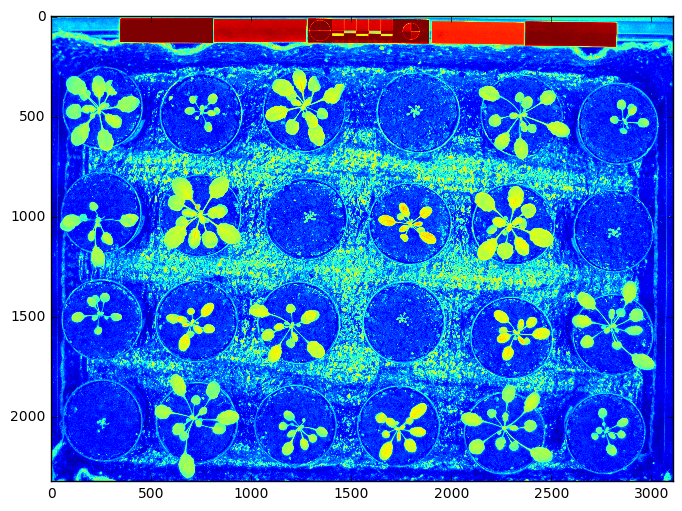

In [21]:
candidate_imgs = np.squeeze(np.array(candidate_imgs))
pred = model.predict(candidate_imgs)

for i, score in enumerate(pred):
    confidence = softmax(score)
    if confidence > 0.5:
        detections.append((coordinates[i][0], coordinates[i][1], confidence,
            int(min_window_size[0]),
            int(min_window_size[1])))
        
#     pred = model.predict(fd)
#     confidence = softmax(pred[0])
#     if confidence > 0.5:
#         detections.append((x, y, clf.decision_function(fd),
#             int(min_window_size[0]),
#             int(min_window_size[1])))
        
# Display the results before performing NMS
clone = im.copy()

# Perform Non Maxima Suppression
left_detections = nms(detections, threshold)

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(clone)

# Display the results after performing NMS
for (x_tl, y_tl, _, w, h) in left_detections:
    # Draw the detections
    rect = patches.Rectangle((x_tl, y_tl), w, h, linewidth=1,edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()

In [22]:
pred

array([[-0.00942735,  0.00860364],
       [-0.010228  ,  0.00807033],
       [-0.0085316 ,  0.00657332],
       ..., 
       [-0.01118174,  0.00906511],
       [-0.01029024,  0.00715898],
       [-0.01126417,  0.00832976]], dtype=float32)